## Read & Visualize the sea ice motion data

In [2]:
import pandas as pd
import glob, os
# import xlrd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import geopandas
import shapefile
import netCDF4
import h5py
import datetime as dt
import pyproj
from tqdm import tqdm
# from mpl_toolkits.basemap import Basemap

# import metpy.calc as mpcalc
# from metpy.units import units

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Sea ice motion (NSIDC)

In [3]:
def get_ice_motion(ncfile, t1, t2, sampling_size = 1, datatype = "NSIDC"):
# ncfile: input monthly ERA5 file (ncfile)
# field: input variable ('sst', 't2m', 'u10', 'v10')
# bounding_box: processed area (Ross Sea - Amundsen Sea)
# latlon_ib: geocoordinates of the iceberg (lat, lon)
# time_ib: date of the iceberg (datetime format)

    with netCDF4.Dataset(ncfile, 'r') as nc:
        keys = nc.variables.keys()
        fields = [k for k in keys]
        fields = ['u', 'v']

        xs = np.array(nc.variables['x'])[::sampling_size]
        ys = np.array(nc.variables['y'])[::sampling_size]  
        xx, yy = np.meshgrid(xs, ys)
        lat = np.array(nc.variables['latitude'])[::sampling_size, ::sampling_size]
        lon = np.array(nc.variables['longitude'])[::sampling_size, ::sampling_size]

        days = np.array(nc.variables['time']).astype(float)

        ind = []
        for i in range(0, len(days)):
            time_era = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[i])
            if (time_era >= t1) and (time_era < t2):
                ind.append(i)

        df = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(),
                           'lat': lat.flatten(), 'lon': lon.flatten()})

        if len(ind) > 0: 
            for field in fields:                

                data2 = []       

                for i in ind:        
                    data = np.array(nc.variables[field][i][::sampling_size, ::sampling_size])
                    # cm/s to km/day
                    data[data == -9999] = np.nan
                    data2.append(data*(3600*24/100000))                        

                data2 = np.array(data2) 
                data_mean = np.array([np.mean(data2, axis = 0)])

                df[field] = data_mean.flatten()

                if field == "u":
                    u = data2 # data_mean
                elif field == "v":
                    v = data2 # data_mean

        df['start_time'] = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[ind[0]])
        df['end_time'] = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[ind[-1]])    

        # nc.close()
#     print("Length of dataframe: {0}".format(len(df)))
    return df, lat, lon, u, v


4it [00:46, 11.58s/it]


DONE!


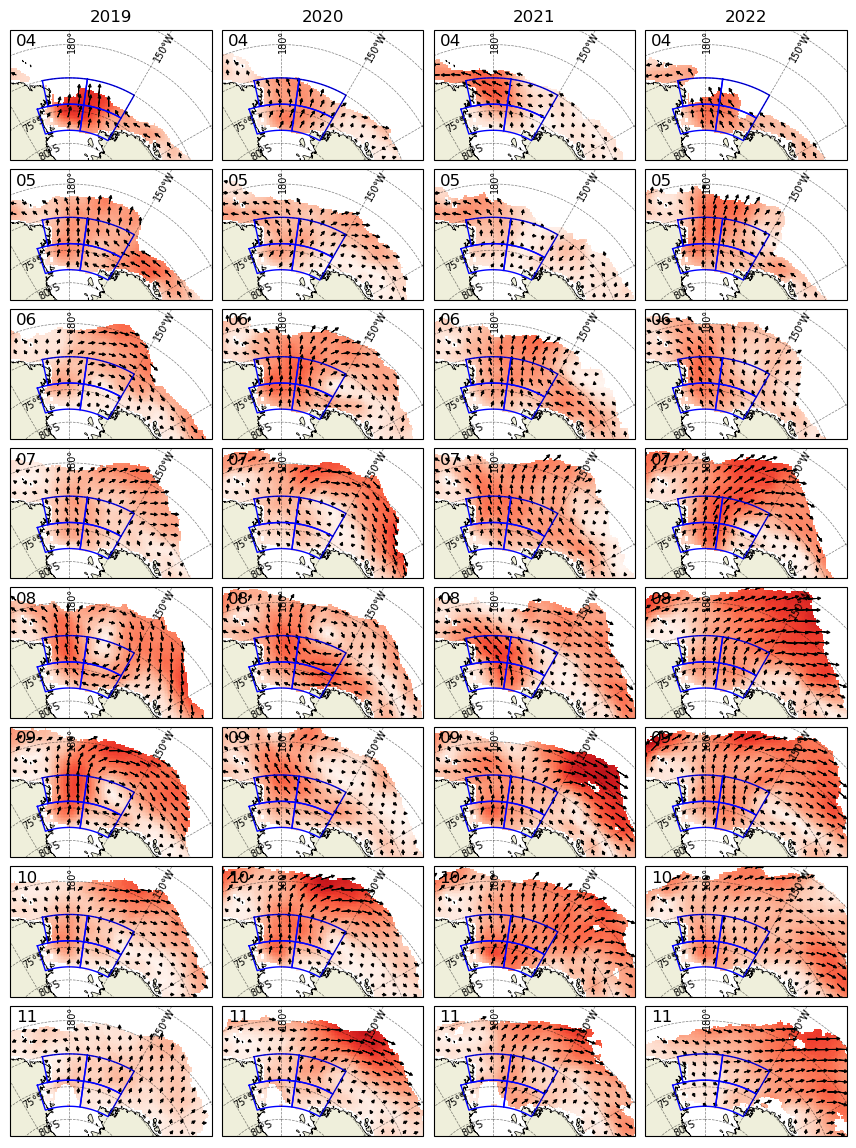

In [12]:
# Read ice motion data

inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3412")
offset = 0.0

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

years = [2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11]

fig, ax = plt.subplots(len(months), len(years), figsize=(len(years)*2.7, len(months)*1.8), dpi= 100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, year in tqdm(enumerate(years)):
    
    ncfile = glob.glob("D:\\Ross\\ice_motion\\icemotion_daily_sh_25km_{0}*.nc".format(year))[0]
    
    for i, month in enumerate(months):
        t1 = dt.datetime(year, month, 1)
        if month == 12:
            t2 = dt.datetime(year+1, 1, 1)
        else:
            t2 = dt.datetime(year, month+1, 1)

        sampling_size = 1
        df, lat, lon, ugrid, vgrid = get_ice_motion(ncfile, t1, t2, sampling_size)
        ugrid = np.mean(ugrid, axis=0)
        vgrid = np.mean(vgrid, axis=0)
        df = df[df['u'] != 0]
        
        data = (ugrid**2 + vgrid**2)**0.5
        
        xx, yy = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), lat, lon)        
        
        pm = ax[i,j].pcolormesh(xx, yy, data, cmap='Reds', vmin=0, vmax=20)
        
        ax[i,j].coastlines('10m', linewidth = 0.5)
        ax[i,j].add_feature(cfeature.LAND)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "b")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "b")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "b")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "b")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                              linewidth=0.5, color='k', alpha = 0.5, linestyle='--')

        # gl.xformatter = LONGITUDE_FORMATTER
        # gl.yformatter = LATITUDE_FORMATTER
        # gl.xlabel_style = {'size': 12, 'color': 'gray'}
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 30}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False

        ax[i,j].annotate('180°', xy=(0.33, 1.0), xycoords='axes fraction', rotation = 90, size = 7, va = 'top', ha ='right')
        ax[i,j].annotate('150°W',xy=(0.83, 1.0), xycoords='axes fraction', rotation = 60, size = 7, va = 'top', ha ='right')

        # xmin, xmax = ax.set_xlim(900000, -1400000)
        # ymin, ymax = ax.set_ylim(-1000000, -2500000)

        # plt.xlim(1000000, -2400000) plt.ylim( -800000, -3000000)
        xmin, xmax = ax[i,j].set_xlim(1000000, -2400000) #xlim(1000000, -1600000)
        ymin, ymax = ax[i,j].set_ylim(-800000, -3000000) #ylim(-800000, -3000000)

        sampling_size = 7
        df0, lat, lon, ugrid, vgrid = get_ice_motion(ncfile, t1, t2, sampling_size)
        ugrid = np.mean(ugrid, axis=0)
        vgrid = np.mean(vgrid, axis=0)
        xgrid, ygrid = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), lat, lon)

        # Ice motion arrows
        xarrow, yarrow = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df0['lat'].values, df0['lon'].values)
        uarrow = np.array(df0['u'])
        varrow = np.array(df0['v'])       

        for k in range(0, len(xarrow)):
            ax[i,j].arrow(xarrow[k], yarrow[k], uarrow[k]*12000, varrow[k]*12000,
                     head_width=50000, head_length=50000, fc='k', ec='k', linewidth = 0.7)

        # plt.colorbar(pm, ax = ax[i,j], shrink = 0.4)
#         clb.set_label('Ice motion (km/day)', rotation = 270, fontsize = 15, va = 'bottom')
#         clb.ax.tick_params(labelsize=15)
        # ax.set_title("{0}".format(year*100+month), fontsize = 12)
        ax[i,j].annotate(str(month).zfill(2), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        if i == 0:
            ax[i,j].set_title("{0}".format(year), fontsize = 12)
        # print(year, month)
plt.savefig('D:\\Ross\\ice_motion\\Icemotion_all_Ross_Amundsen.png', bbox_inches = "tight")
print("DONE!")

In [33]:
df0['lon']

0      -135.000000
1      -135.909378
2      -136.847610
3      -137.815552
4      -138.814072
           ...    
4220     41.185925
4221     42.184444
4222     43.152390
4223     44.090618
4224     45.000000
Name: lon, Length: 4225, dtype: float32